# Classification on activations
We saw earlier that activations (from the last token, for some layers) from true and false statements were linearly separable. We will now train try and train a classifier on these activations to see if we can classify true and false statements.

We will start by using only the activations from the layers 10 or 18 which are the most easily separable ones and then we'll try to use the activations from all the layers to see if the classifier still manages to make correct predictions (which would enable a more general way to train it that could be extended to other models easily).

### Load data from 10th layer
We will start by loading the activations from the 10th layer and the labels for the true and false statements.

In [56]:
import pandas as pd


def load_nth_layer_data(nth, dataset='cities'):
    data_path = f'../data/activations/{dataset}/layer_{nth}_output_{dataset}.csv'
    data = pd.read_csv(data_path, header=None)

    # Data has no column names, so we add them here
    nb_activation_by_layer = data.shape[1] - 1
    columns = [f'activation_{nth*nb_activation_by_layer + i}' for i in range(nb_activation_by_layer)] + ['label']
    data.columns = columns

    ######## Remove when data is fixed ########
    # for col in data.columns:
    #     # Apply the replacement operation to remove the second point from all values
    #     data[col] = data[col].astype(str).str.replace(r'(\d+\.\d+)\.(\d+)(.*)', r'\1\2', regex=True)

    # # Convert all columns to float
    # try:
    #     data = data.astype(float)
    # except ValueError:
    #     print("Error: Could not convert the data to float. Make sure that the data does not contain any non-numeric values.")
    #     return None
    ###########################################

    return data

data = load_nth_layer_data(10, 'cities')

print(f'Data contains {data.shape[1] - 1} activation values for {data.shape[0]} statements')
print('The last column contains the labels (1 for true, 0 for false)')

Data contains 5120 activation values for 1496 statements
The last column contains the labels (1 for true, 0 for false)


### Train a classifier
The first classifier we will use is a logistic regression that fits well the binary classification problem we have here.

In [57]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score


def get_accuracy(data, clf, random_state=42, nb_train=None, data_test=None, nb_test=None):
    if nb_train is None:
        nb_train = data.shape[0]
    if nb_test is None and data_test is not None:
        nb_test = data_test.shape[0]
    if data_test is None:
        x = data.iloc[:nb_train, :-1]
        y = data.iloc[:nb_train, -1]

        x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=random_state)
    else:
        x_train, y_train = data.iloc[:nb_train, :-1], data.iloc[:nb_train, -1]
        x_test, y_test = data_test.iloc[:nb_test, :-1], data_test.iloc[:nb_test, -1]

    clf.fit(x_train, y_train)

    y_pred = clf.predict(x_test)

    accuracy = accuracy_score(y_test, y_pred)
    return accuracy

In [58]:
from sklearn.linear_model import LogisticRegression


nth = 10
data = load_nth_layer_data(nth, 'cities')

clf = LogisticRegression(max_iter=1000)
accuracy = get_accuracy(data, clf)
print(f'Accuracy of {clf.__class__.__name__} on layer {nth} activations: {accuracy:.2f}')

Accuracy of LogisticRegression on layer 10 activations: 0.99


We can also try to train a Random Forest classifier.

In [59]:
from sklearn.ensemble import RandomForestClassifier


nth = 10
data = load_nth_layer_data(nth, 'cities')

clf = RandomForestClassifier()
accuracy = get_accuracy(data, clf)
print(f'Accuracy of {clf.__class__.__name__} on layer {nth} activations: {accuracy:.2f}')

Accuracy of RandomForestClassifier on layer 10 activations: 0.99


### Plotting accuracy

We can first plot the accuracy on the 'cities' dataset for classifiers trained on the same dataset.

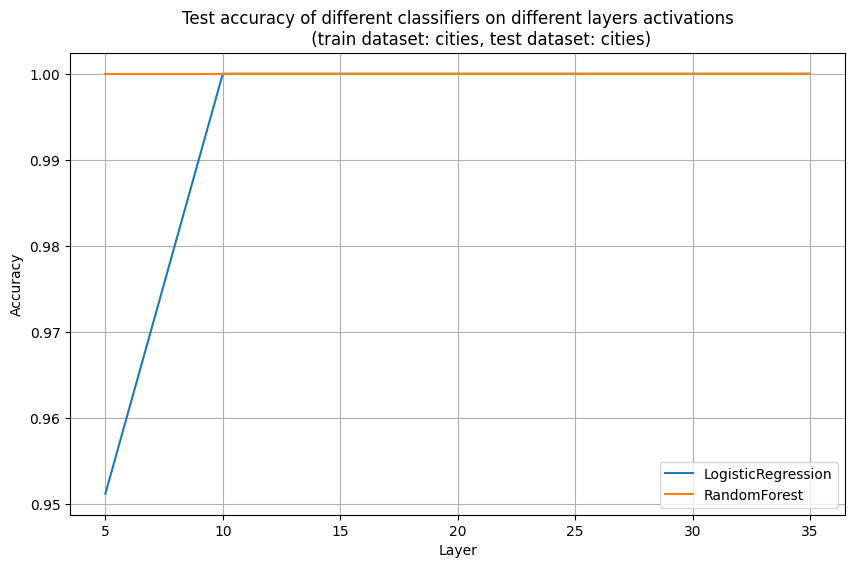

In [60]:
import matplotlib.pyplot as plt


def plot_accuracy(layers, clfs, train_dataset='cities', test_dataset=None):
    accuracies = {clf.__class__.__name__: [] for clf in clfs}

    for nth in layers:
        data_train = load_nth_layer_data(nth, train_dataset)
        if test_dataset is not None:
            data_test = load_nth_layer_data(nth, test_dataset)
        else:
            data_test = None
        for clf in clfs:
            accuracy = get_accuracy(data_train, clf, data_test=data_test)
            accuracies[clf.__class__.__name__].append(accuracy)

    plt.figure(figsize=(10, 6))
    for clf, acc in accuracies.items():
        plt.plot(layers, acc, label=clf.replace('Classifier', ''))
    plt.xlabel('Layer')
    plt.ylabel('Accuracy')
    plt.title(f'Test accuracy of different classifiers on different layers activations\n \
        (train dataset: {train_dataset}, test dataset: {test_dataset})')
    plt.legend()
    plt.grid()
    plt.show()

layers = [5, 10, 18, 25, 35]
clfs = [LogisticRegression(max_iter=1000), RandomForestClassifier()]

plot_accuracy(layers, clfs, 'cities', 'cities')

We can now do the same thing but with a test set that contains different type of statements.

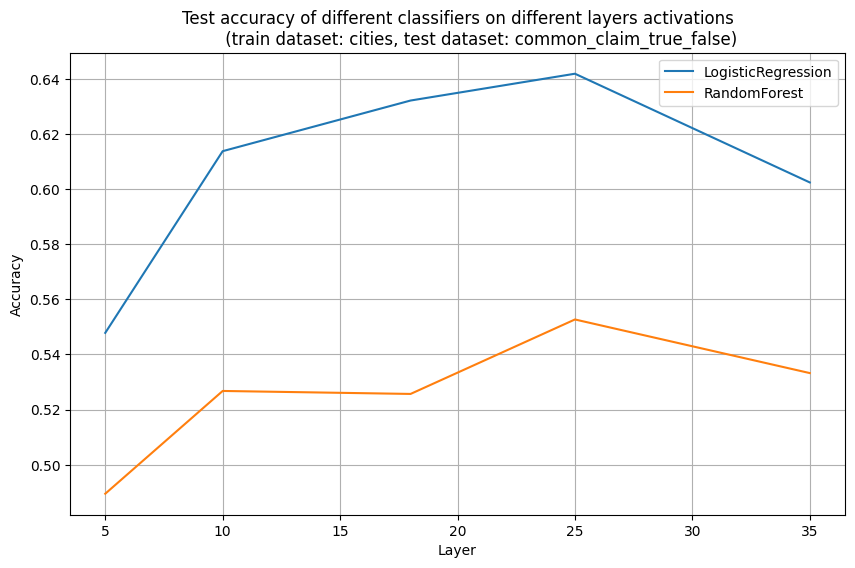

In [61]:
layers = [5, 10, 18, 25, 35]
clfs = [LogisticRegression(max_iter=1000), RandomForestClassifier()]

plot_accuracy(layers, clfs, 'cities', 'common_claim_true_false')

We can also try to train and test on a dataset that contains statements from several different datasets.

In [73]:
def load_mixed_data(layers, datasets):
    mixed_datasets = [pd.concat([load_nth_layer_data(nth, dataset) for dataset in datasets], axis=0) for nth in layers]
    return mixed_datasets

In [76]:
layers = [5, 10, 18, 25, 35]
datasets = ['cities', 'common_claim_true_false']
mixed_datasets = load_mixed_data(layers, datasets)

print(f'Loaded {len(layers)} layers activations for {len(datasets)} datasets')
print(f'Each layer has {mixed_datasets[0].shape[1] - 1} activation values for {mixed_datasets[0].shape[0]} statements')

Loaded 5 layers activations for 2 datasets
Each layer has 5120 activation values for 3347 statements


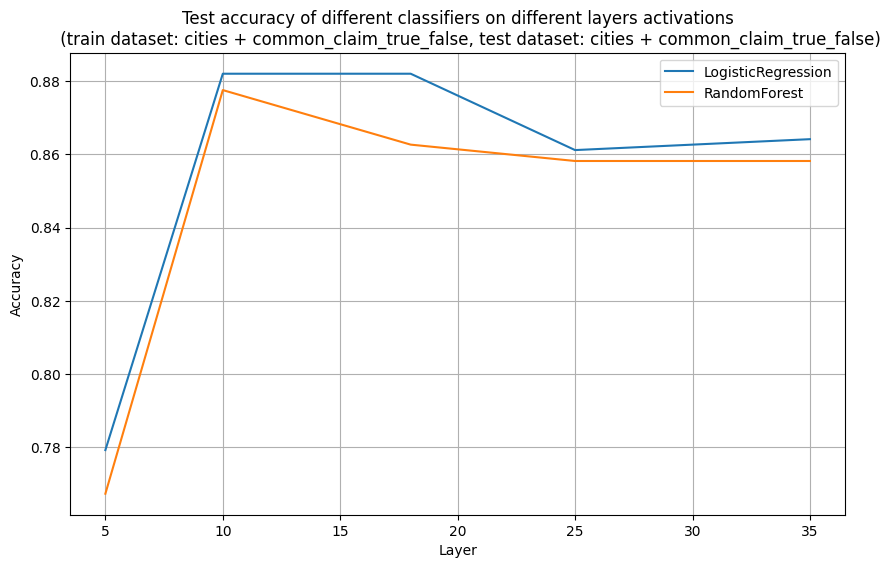

In [77]:
# Refactoring the plot function would be prettier
clfs = [LogisticRegression(max_iter=1000), RandomForestClassifier()]
accuracies = {clf.__class__.__name__: [] for clf in clfs}

for i, nth in enumerate(layers):
    for clf in clfs:
        accuracy = get_accuracy(mixed_datasets[i], clf)
        accuracies[clf.__class__.__name__].append(accuracy)

plt.figure(figsize=(10, 6))
for clf, acc in accuracies.items():
    plt.plot(layers, acc, label=clf.replace('Classifier', ''))
plt.xlabel('Layer')
plt.ylabel('Accuracy')
plt.title(f'Test accuracy of different classifiers on different layers activations\n \
    (train dataset: {" + ".join(datasets)}, test dataset: {" + ".join(datasets)})')
plt.legend()
plt.grid()
plt.show()

### Merging activations from all layers
We will now try to merge the activations from all the layers and train a classifier on these.

In [78]:
def load_merged_data(layers=[5, 10, 18, 25, 35], dataset='cities'):
    datas = [load_nth_layer_data(nth, dataset) for nth in layers]
    for i in range(len(datas) - 1):
        datas[i].drop(datas[i].columns[-1], axis=1, inplace=True)

    data = pd.concat(datas, axis=1)
    
    return data

layers = [5, 10, 18, 25, 35]
data = load_merged_data(layers, 'cities')
print(f'Data contains {data.shape[1] - 1} activation values from {len(layers)} layers for {data.shape[0]} statements')
print('The last column contains the labels (1 for true, 0 for false)')

Data contains 25600 activation values from 5 layers for 1496 statements
The last column contains the labels (1 for true, 0 for false)


First on the same test and train set.

In [79]:
train_dataset = 'cities'

data_train = load_merged_data(layers, train_dataset)

print(f'Training on {train_dataset} dataset, testing on {train_dataset}')
acc = get_accuracy(data_train, RandomForestClassifier())
print(f'Accuracy of RandomForestClassifier on merged layers activations: {acc:.2f}')

acc = get_accuracy(data_train, LogisticRegression(max_iter=1000))
print(f'Accuracy of LogisticRegression on merged layers activations: {acc:.2f}')

Training on cities dataset, testing on cities
Accuracy of RandomForestClassifier on merged layers activations: 1.00
Accuracy of LogisticRegression on merged layers activations: 1.00


Then on a different test set.

In [80]:
train_dataset = 'cities'
test_dataset = 'common_claim_true_false'

data_train = load_merged_data(layers, train_dataset)
if test_dataset is not None:
    data_test = load_merged_data(layers, test_dataset)
else:
    data_test = None

print(f'Training on {train_dataset} dataset, testing on {test_dataset if test_dataset is not None else train_dataset}')
acc = get_accuracy(data_train, RandomForestClassifier(), data_test=data_test)
print(f'Accuracy of RandomForestClassifier on merged layers activations: {acc:.2f}')

acc = get_accuracy(data_train, LogisticRegression(max_iter=1000), data_test=data_test)
print(f'Accuracy of LogisticRegression on merged layers activations: {acc:.2f}')

Training on cities dataset, testing on common_claim_true_false
Accuracy of RandomForestClassifier on merged layers activations: 0.53
Accuracy of LogisticRegression on merged layers activations: 0.64


And finally on a dataset that contains statements from several different datasets.

In [81]:
datasets = ['cities', 'common_claim_true_false']
mixed_datasets = load_mixed_data(layers, datasets)
for i in range(len(mixed_datasets)-1):
    mixed_datasets[i].drop(mixed_datasets[i].columns[-1], axis=1, inplace=True)

data = pd.concat(mixed_datasets, axis=1)
print(f'Data contains {data.shape[1] - 1} activation values from {len(layers)} layers for {data.shape[0]} statements\n')

print(f'Training on {" + ".join(datasets)} dataset, testing on {" + ".join(datasets)}')
acc = get_accuracy(data, RandomForestClassifier())
print(f'Accuracy of RandomForestClassifier on merged layers activations: {acc:.2f}')

acc = get_accuracy(data, LogisticRegression(max_iter=1000))
print(f'Accuracy of LogisticRegression on merged layers activations: {acc:.2f}')

Data contains 25600 activation values from 5 layers for 3347 statements

Training on cities + common_claim_true_false dataset, testing on cities + common_claim_true_false
Accuracy of RandomForestClassifier on merged layers activations: 0.87
Accuracy of LogisticRegression on merged layers activations: 0.87


### Locating the most important activation values
Now we know that the classifiers can make accurate predictions using the activations from all the layers, we can try to locate the most important activation values for the classifier.

We can use the feature importance from the Random Forest classifier to see which activations are the most important.

In [65]:
layers = [5, 10, 18, 25, 35]
data = load_merged_data(layers)
clf = RandomForestClassifier()

# Fit the model on the whole dataset
_ = get_accuracy(data, clf)

In [66]:
importances = clf.feature_importances_
# Scale the importances between 0 and 1
importances = importances / importances.max()

print(f'Importances shape: {importances.shape}')
nb_activations_by_layer = (data.shape[1] - 1) // len(layers)
importances = importances.reshape(len(layers), nb_activations_by_layer)
print(f'Importances shape after reshaping: {importances.shape}')

most_important_activation = importances.argmax()
print(f'Most important activation is at position {most_important_activation % nb_activations_by_layer} in layer {layers[most_important_activation // nb_activations_by_layer]}')

importances_sums = importances.sum(axis=1)
most_important_layer = importances_sums.argmax()
print(f'Most important layer is {layers[most_important_layer]}')

Importances shape: (25600,)
Importances shape after reshaping: (5, 5120)
Most important activation is at position 3355 in layer 18
Most important layer is 18


In [67]:
import numpy as np
import seaborn as sns
import math


def plot_heatmaps(importances, layers):
    original_shape = (128, 40)
    importances_reshaped = []
    for i in range(len(importances)):
        importances_reshaped.append(np.array(importances[i]).reshape(original_shape))
    
    ncols = 2
    nrows = math.ceil(len(importances) / ncols)

    fig, axs = plt.subplots(nrows, ncols, figsize=(15, 15))
    for i, ax in enumerate(axs.flat):
        if i < len(importances):
            ax = sns.heatmap(importances_reshaped[i], cmap='coolwarm', square=False, vmin=0, vmax=1, ax=ax)
            ax.set_title(f'Layer {layers[i]} Activation Importance Heatmap')
            ax.set_xlabel('Neuron x-coordinate')
            ax.set_ylabel('Neuron y-coordinate')
        else:
            fig.delaxes(ax)
    
    plt.tight_layout(pad=2.0)
    plt.show()

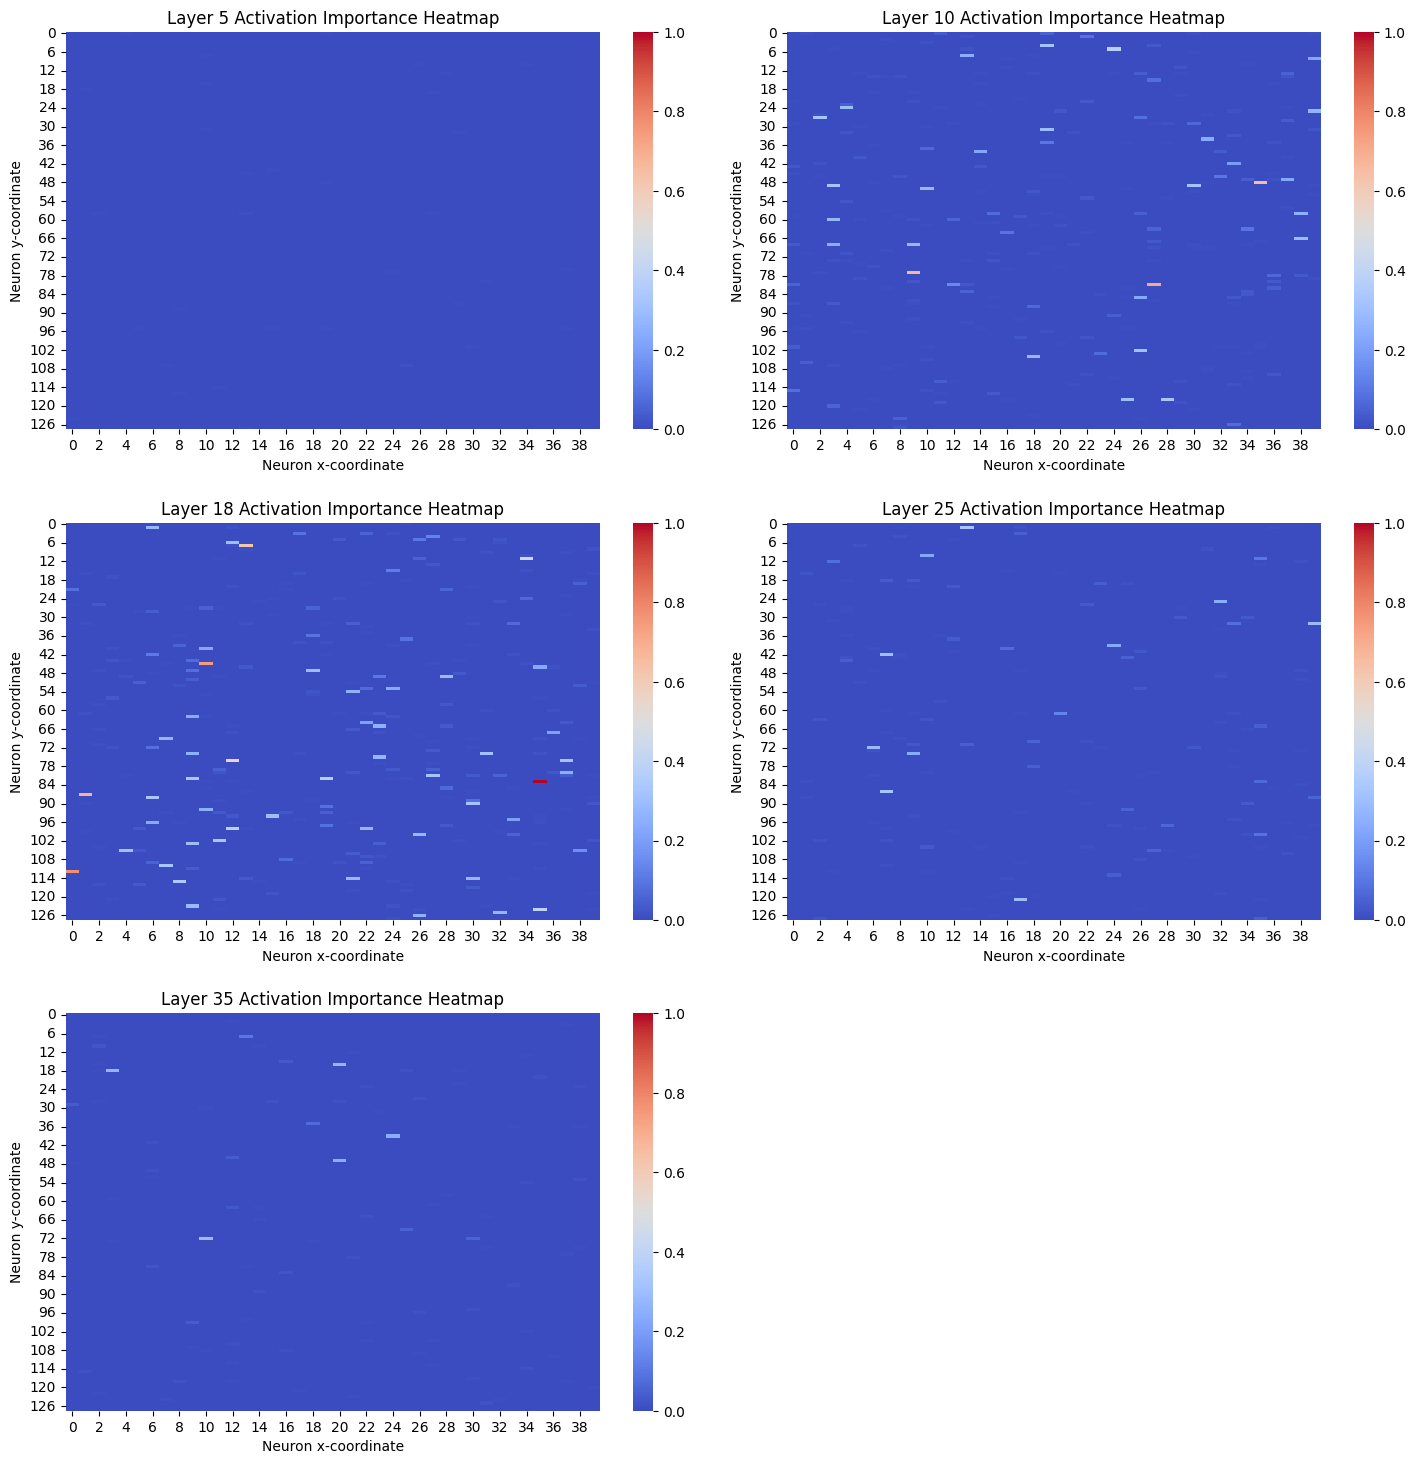

In [68]:
plot_heatmaps(importances, layers)